In [1]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.modeling import models, fitting
from photutils import isophote, aperture_photometry
from photutils import CircularAperture, EllipticalAperture, EllipticalAnnulus
from photutils.isophote import EllipseGeometry, Ellipse
import ipywidgets
from luminosity import surface_brightness

In [2]:
def kpc2pix(qty_kpc, width, resolution):
    kpc_per_pixel = width/resolution
    return int(np.floor(qty_kpc/kpc_per_pixel))

In [3]:
def bounding_box(snap):
    unit = snap['pos'].units
    for coord in 'x y z'.split():
        print("{}: {:10.2f}, {:10.2f} ({})".format(coord, snap[coord].min(), snap[coord].max(), unit))
    return [(float(snap[coord].min()), float(snap[coord].max())) for coord in 'x y z'.split()]

In [4]:
def to_astropy_quantity(simarr, units=None):
    return u.Quantity(simarr.view(type=np.ndarray), unit=units if units is not None else str(simarr.units))

In [5]:
def ss_angmom(flux, r, v_los, v_disp):
    return np.sum(flux * r * np.abs(v_los)) / np.sum(flux * r * np.sqrt(v_los**2 + v_disp**2))
def compute_stellar_specific_angmom(snap, width, resolution, radii, eccentricity, a_delta, theta):
    luminosity_sim = surface_brightness(snap.s, band='v', width=width, resolution=resolution, mag_filter=None, cmap_name='Greys')
    v_los_sim = pynbody.plot.sph.image(snap.s, qty='vz', av_z='rho', width=width, resolution=resolution, log=False)
    v_disp_sim = pynbody.plot.sph.image(snap.s, qty='v_disp', av_z='rho', width=width, resolution=resolution, log=False)
    lum = to_astropy_quantity(luminosity_sim, units='mag/arcsec**2')
    v_los = to_astropy_quantity(v_los_sim)
    v_disp = to_astropy_quantity(v_disp_sim)
    lum_annuli = integrate_annulus(lum, center, radii, eccentricity, a_delta, theta)
    v_los_annuli = integrate_annulus(v_los, center, radii, eccentricity, a_delta, theta)
    v_disp_annuli = integrate_annulus(v_disp, center, radii, eccentricity, a_delta, theta)
    stellar_specific_angmom = ss_angmom(lum_annuli, radii, v_los_annuli, v_disp_annuli)
    return stellar_specific_angmom

In [6]:
def fit_sersic(img, r_eff, n, ellip, theta):
    res_x, res_y = img.shape
    y, x = np.mgrid[:res_x, :res_y]
    s_init = models.Sersic2D(r_eff=r_eff, n=n, x_0=res_x/2, y_0=res_y/2, ellip=ellip, theta=theta,
                         fixed={'amplitude':False, 'n':False, 'ellip':False, 'x_0':True, 'y_0':True},
                         bounds={})#'theta':(0, np.pi)})
    fit_s = fitting.SLSQPLSQFitter()
    # notnans = np.isfinite(img)
    # sersic = fit_s(s_init, x[notnans], y[notnans], img[notnans])
    sersic = fit_s(s_init, x, y, img)
    return sersic

In [7]:
def plot_fit(img, fit):
    # Plot the data with the best-fit model
    res_x, res_y = img.shape
    y, x = np.mgrid[:res_x, :res_y]
    plt.figure(figsize=(8,2.5))
    plt.subplot(1,3,1)
    plt.imshow(img, origin='lower', interpolation='nearest')
    plt.title("Data")
    plt.subplot(1,3,2)
    plt.imshow(fit(x, y), origin='lower', interpolation='nearest')
    plt.title("Model")
    plt.subplot(1,3,3)
    plt.imshow(img - fit(x, y), origin='lower', interpolation='nearest', cmap='seismic')
    plt.title("Residual");

In [8]:
snap = "/home/michele/sim/MoRIA/M1-10_Verbeke2017/M10sim41001/snapshot_0036"
s = pynbody.load(snap)

In [9]:
max_boxsize = 4000

In [10]:
s.properties['boxsize'] = pynbody.units.Unit("{} kpc".format(max_boxsize))

In [11]:
width = 10
resolution=500

In [53]:
pynbody.analysis.halo.center(s.s)#, vel=False)
subsnap = s[pynbody.filt.Cuboid('{} kpc'.format(-width*1.1))]

Plot density

array([0.9163727 , 0.38866973, 0.55933464], dtype=float32)

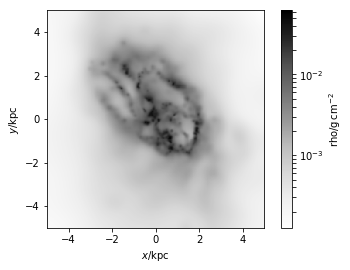

In [54]:
pynbody.plot.sph.image(s.g,qty="rho", units="g cm^-2", width=width, cmap="Greys");
L = pynbody.analysis.angmom.ang_mom_vec(s.star)
L

array([ 0.63001364, -0.10349182,  0.28363314], dtype=float32)

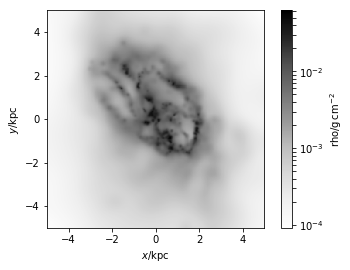

In [55]:
pynbody.plot.sph.image(subsnap.g,qty="rho", units="g cm^-2", width=width, cmap="Greys");
L = pynbody.analysis.angmom.ang_mom_vec(subsnap.star)
L

array([ 0.63001364, -0.10349182,  0.28363314], dtype=float32)

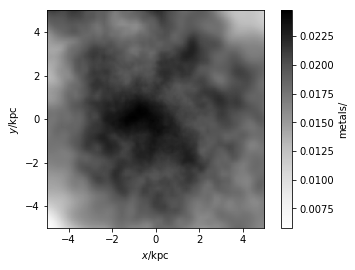

In [56]:
# pynbody.plot.sph.image(subsnap.s, qty="age", av_z=True, units="Gyr", width=width, cmap="Greys", log=False);
pynbody.plot.sph.image(subsnap.s, qty="metals", av_z=True, width=width, cmap="Greys", log=False);
L = pynbody.analysis.angmom.ang_mom_vec(subsnap.star)
L

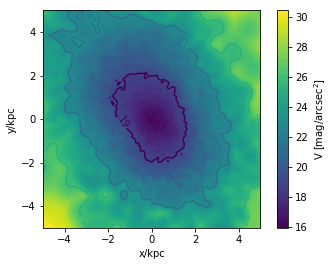

In [69]:
fig, ax = plt.subplots()
extent=(-width/2, width/2, -width/2, width/2)
sb = surface_brightness(subsnap.s, width=width, resolution=resolution, 
                        mag_filter=None, subplot=ax)
cont = ax.contour(sb, levels=np.linspace(sb.min(), sb.max(), 5, dtype=np.int), extent=extent)
# img = surface_brightness(subsnap.s, band='v', width=width, resolution=resolution, mag_filter=None, subplot=ax)
# cont = ax.contour(img, cmap='viridis', levels=np.arange(18, 34, 4, dtype=np.int), extent=(-width/2, width/2, -width/2, width/2))
ax.clabel(cont, inline=1, fmt='%1.0f');

In [70]:
np.linspace(sb.min(), sb.max(), 5, dtype=np.int)

SimArray([15, 19, 23, 26, 30], 'arcsec**-2')

/home/michele/Software/miniconda3/lib/python3.6/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


('n: ', 1.4779186921131644, '  other: ', 17.318478561437075)


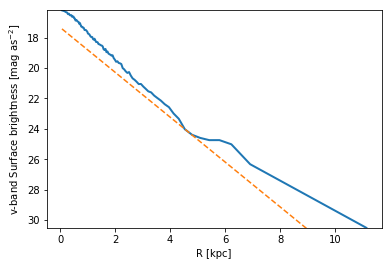

In [58]:
pynbody.plot.sbprofile(subsnap, fit_sersic=True)

(0, 11.988018)

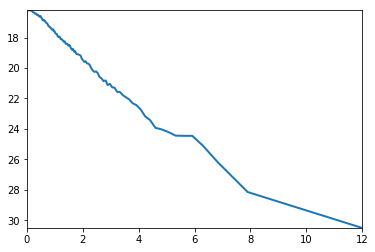

In [60]:
binning='equaln'
band='v'
ps = pynbody.analysis.profile.Profile(subsnap.s, type=binning)
r = ps['rbins'].in_units('kpc')
plt.plot(r, ps['sb,' + band], linewidth=2)
plt.ylim(max(ps['sb,' + band]), min(ps['sb,' + band]))
plt.xlim(0, max(r))

In [42]:
r_eff_kpc = pynbody.analysis.luminosity.half_light_r(subsnap, cylindrical=True)
r_eff_kpc

SimArray(1.01581584, 'kpc')

In [43]:
r_eff = kpc2pix(r_eff_kpc, width, resolution)
r_eff

50

In [44]:
ellipticity = 0.5
theta = 120*np.pi/180
n=1

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 132028082.75906269
            Iterations: 2
            Function evaluations: 16
            Gradient evaluations: 2


<Sersic2D(amplitude=1.99317119, r_eff=50., n=1.43858995, x_0=250., y_0=250., ellip=0.50000103, theta=2.0943951)>

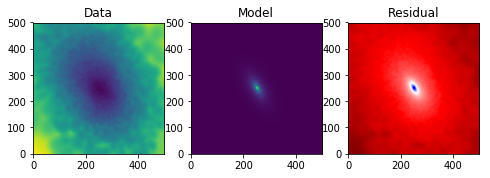

In [51]:
y, x = np.mgrid[:resolution, :resolution]
s_init = models.Sersic2D(r_eff=r_eff, n=1, x_0=resolution/2, y_0=resolution/2, ellip=0.5, theta=theta,
                      fixed={'amplitude':False, 'r_eff':True, 'n':False, 'x_0':True, 'y_0':True, 'ellip':False, 'theta':True},
                     bounds={'theta':(0, np.pi), 'ellip':(0,1)})
fit_s = fitting.SLSQPLSQFitter()
# notnans = np.isfinite(img)
# sersic = fit_s(s_init, x[notnans], y[notnans], img[notnans])
sersic = fit_s(s_init, x, y, sb)
plot_fit(sb, sersic)
sersic

In [42]:
fit_s.fit_info['message']

{'final_func_val': nan,
 'numiter': 101,
 'exit_mode': 9,
 'message': 'Iteration limit exceeded'}

In [58]:
sersic = fit_sersic(sb, r_eff=23, n=2, ellip=ellipticity, theta=theta)
sersic

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1858190.3523806308
            Iterations: 41
            Function evaluations: 353
            Gradient evaluations: 41


<Sersic2D(amplitude=23.00848138, r_eff=261.10699231, n=0.00298683, x_0=250., y_0=250., ellip=-5.36146787, theta=-0.60358277)>

In [39]:
sersic

<Sersic2D(amplitude=23.00848138, r_eff=261.10699231, n=0.00298683, x_0=250., y_0=250., ellip=-5.36146787, theta=-0.60358277)>

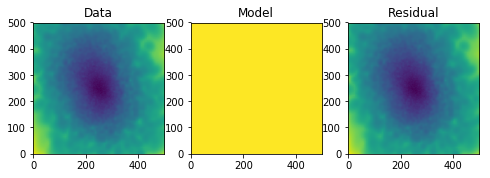

In [40]:
plot_fit(sb, sersic)

In [ ]:
a_delta = 20
radii = np.arange(30, 200, a_delta)

In [ ]:
compute_stellar_specific_angmom(subsnap)

In [11]:
half_light_radius = pynbody.analysis.luminosity.half_light_r(s, cylindrical=False)
half_light_radius

SimArray(1.22971601, 'kpc')

In [12]:
max_r = 10 * half_light_radius
radius_slider = ipywidgets.IntSlider(min=0, max=max_r, value=5)
width_slider = ipywidgets.IntSlider(min=0, max=max_r, value=width)
vel_slider = ipywidgets.IntSlider(min=0, max=100, value=10, step=5)

def k(r, w, v):
    subsnap = s[pynbody.filt.Cuboid('{} kpc'.format(-r))]
    print(pynbody.analysis.angmom.ang_mom_vec(subsnap.s))
    pynbody.analysis.angmom.sideon(subsnap.s)
    print(pynbody.analysis.angmom.ang_mom_vec(subsnap.s))
#     fig, ((ax1, ax2, ax3), (cb1, cb2, cb3)) = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
    fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, figsize=(12, 6))
    vlos = pynbody.plot.sph.image(subsnap.s, qty='vz', av_z=True, width=w, resolution=resolution, log=False,
                           vmin=-v, vmax=v, show_cbar=False, subplot=ax1)
    
#     fig, ax2 = plt.subplots()#surface_brightness(s, width=width, resolution=resolution);
    sigma = pynbody.plot.sph.image(subsnap.s, qty='v_disp', av_z=True, width=w, resolution=resolution, log=False,
                           show_cbar=False, subplot=ax2)

#     cbar2 = cb2.figure.colorbar(sigma);
#     cbar2.set_label('{} [{}]'.format("$\sigma", subsnap.s['v_disp'].units));

    flux = surface_brightness(subsnap, width=w, resolution=resolution, subplot=ax3, show_cbar=False);
#     cmap = plt.get_cmap(cmap_name)
#     cmap.set_bad('black')
#     cbar3 = cb3.figure.colorbar(flux);
#     cbar3.set_label('{} [mag/arcsec$^2$]'.format(band.upper()));
    
    fig.subplots_adjust(wspace=0.3)
    
w = ipywidgets.interactive(k, r=radius_slider, w=width_slider, v=vel_slider)
w

interactive(children=(IntSlider(value=5, description='r', max=12), IntSlider(value=8, description='w', max=12)…

In [53]:
max_r = 10 * half_light_radius
radius_slider = ipywidgets.IntSlider(min=0, max=max_r, value=5)
width_slider = ipywidgets.IntSlider(min=0, max=max_r, value=width)
vel_slider = ipywidgets.IntSlider(min=0, max=100, value=10, step=5)

def k(r, w, v):
    subsnap = s[pynbody.filt.Cuboid('{} kpc'.format(-r))]
#     print(pynbody.analysis.angmom.ang_mom_vec(subsnap.s))
    pynbody.analysis.angmom.sideon(subsnap.s)
#     print(pynbody.analysis.angmom.ang_mom_vec(subsnap.s))
    figsize=None#(6,6)
    fig1, ax1 = plt.subplots(figsize=figsize)
    vlos = pynbody.plot.sph.image(subsnap.s, qty='vz', av_z=True, width=w, resolution=resolution, log=False,
                           vmin=-v, vmax=v, show_cbar=True, subplot=ax1)
    
    fig2, ax2 = plt.subplots(figsize=figsize)
    sigma = pynbody.plot.sph.image(subsnap.s, qty='v_disp', av_z=True, width=w, resolution=resolution, log=False,
                           show_cbar=True, subplot=ax2)

#     cbar2 = cb2.figure.colorbar(sigma);
#     cbar2.set_label('{} [{}]'.format("$\sigma", subsnap.s['v_disp'].units));
    fig3, ax3 = plt.subplots(figsize=figsize)
    flux = surface_brightness(subsnap, width=w, resolution=resolution, subplot=ax3, show_cbar=True);
#     cmap = plt.get_cmap(cmap_name)
#     cmap.set_bad('black')
#     cbar3 = cb3.figure.colorbar(flux);
#     cbar3.set_label('{} [mag/arcsec$^2$]'.format(band.upper()));    
w = ipywidgets.interactive(k, r=radius_slider, w=width_slider, v=vel_slider, show_cbar=False)
w

interactive(children=(IntSlider(value=5, description='r', max=12), IntSlider(value=8, description='w', max=12)…